# Detection models test per package


In [2]:
import os
import sys

import numpy as np
from collections import defaultdict
from PIL import Image
from PIL import ImageDraw

from matplotlib import pyplot as plt

%matplotlib inline


In [3]:
test_image_path = [
    os.path.join("data/object_detection/test", "frame_000011.JPEG"),
    # os.path.join("data/object_detection/test", "frame_000024.JPEG"),
    # os.path.join("data/object_detection/test", "frame_000033.JPEG"),
    # os.path.join("data/object_detection/test", "frame_000163.JPEG"),
    # os.path.join("data/object_detection/test", "frame_000203.JPEG"),
]


## Tensorflow Test


In [3]:
import tensorflow as tf

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util


2022-11-07 20:21:55.484124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 20:21:55.848001: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-07 20:21:55.896064: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 20:21:57.527326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [4]:
frozen_inference_graph_path = (
    "objects_on_road_processor/model/ssd_mobilenet_v2_quantized/frozen_inference_graph.pb"
)
label_map = "data/object_detection/annotations/label_map.pbtxt"


In [5]:
# Initialize tf.Graph()
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.compat.v1.gfile.GFile(frozen_inference_graph_path, "rb") as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name="")

# Loads labels
label_map = label_map_util.load_labelmap(label_map)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=1, use_display_name=True
)
category_index = label_map_util.create_category_index(categories)

# Run Inference and populates results in a dict.
def run_inference(graph, image):
    with graph.as_default():
        with tf.compat.v1.Session() as sess:
            ops = tf.compat.v1.get_default_graph().get_operations()
            all_tensor_names = [output.name for op in ops for output in op.outputs]
            tensor_dict = {}
            tensor_keys = [
                "num_detections",
                "detection_boxes",
                "detection_scores",
                "detection_classes",
            ]
            for key in tensor_keys:
                tensor_name = key + ":0"
                if tensor_name in all_tensor_names:
                    tensor_dict[
                        key
                    ] = tf.compat.v1.get_default_graph().get_tensor_by_name(tensor_name)

            # Actual inference.
            image_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name(
                "image_tensor:0"
            )
            output_dict = sess.run(
                tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)}
            )

            output_dict["num_detections"] = int(output_dict["num_detections"][0])
            output_dict["detection_classes"] = output_dict["detection_classes"][
                0
            ].astype(np.uint8)
            output_dict["detection_boxes"] = output_dict["detection_boxes"][0]
            output_dict["detection_scores"] = output_dict["detection_scores"][0]
    return output_dict


for image_path in test_image_path:
    print("Evaluating:", image_path)
    image = Image.open(image_path)
    img_width, img_height = image.size
    image_np = (
        np.array(image.getdata()).reshape((img_height, img_width, 3)).astype(np.uint8)
    )
    # Run inference.
    output_dict = run_inference(detection_graph, image_np)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict["detection_boxes"],
        output_dict["detection_classes"],
        output_dict["detection_scores"],
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8,
    )
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)


Evaluating: data/object_detection/test/frame_000011.JPEG


2022-11-07 20:22:01.032112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 20:22:01.051209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 20:22:01.052351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 20:22:01.056171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

## TFLite test


In [1]:
import tflite_runtime.interpreter as tflite
import re


In [17]:
tflite_model_path = "objects_on_road_processor/model/ssd_mobilenet_v2_quantized/tflite/ssd_mobilenet_v2_quantized.tflite"


In [23]:
def tflite_read_label_file(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    ret = {}
    for row_number, content in enumerate(lines):
        pair = re.split(r"[:\s]+", content.strip(), maxsplit=1)
        if len(pair) == 2 and pair[0].strip().isdigit():
            ret[int(pair[0])] = pair[1].strip()
        else:
            ret[row_number] = content.strip()
    return ret


def tflite_set_input(interpreter: tflite.Interpreter, image: np.ndarray):
    input_details = interpreter.get_input_details()

    width = input_details[0]["shape"][2]
    height = input_details[0]["shape"][1]
    resized_image = image.resize((width, height))
    np_image = np.asarray(resized_image)
    input_tensor = np.expand_dims(np_image, axis=0)

    interpreter.set_tensor(input_details[0]["index"], input_tensor)


def tflite_run_inference(interpreter):
    output_details = interpreter.get_output_details()
    interpreter.invoke()
    boxes = interpreter.get_tensor(output_details[0]["index"])[0]
    classes = interpreter.get_tensor(output_details[1]["index"])[0]
    scores = interpreter.get_tensor(output_details[2]["index"])[0]
    # num_detections = interpreter.get_tensor(output_details[3]['index'])[0]
    return boxes, classes, scores


In [24]:
image_path = test_image_path[0]

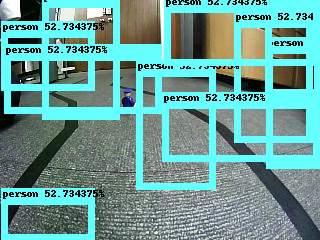

In [30]:
interpreter = tflite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
interpreter.invoke() # warmup

image = Image.open(image_path)
image_width, image_height = image.size
draw = ImageDraw.Draw(image)
tflite_set_input(interpreter, image)
boxes, classes, scores = tflite_run_inference(interpreter)

labels = tflite_read_label_file("objects_on_road_processor/model/ssdlite_mobiledet/labels.txt")
for i in range(len(boxes)):
    if scores[i] > .3:
        ymin = int(max(1, (boxes[i][0] * image_height)))
        xmin = int(max(1, (boxes[i][1] * image_width)))
        ymax = int(min(image_height, (boxes[i][2] * image_height)))
        xmax = int(min(image_width, (boxes[i][3] * image_width)))
        draw.rectangle((xmin, ymin, xmax, ymax), width=7, outline=(102, 255, 255))
        draw.rectangle((xmin, ymin, xmax, ymin-10), fill=(102, 255, 255))
        text = labels[int(classes[i])] + ' ' + str(scores[i]*100) + '%'
        draw.text((xmin+2, ymin-10), text, fill=(0,0,0), width=2)
        
display(image)

## TFLite EdgeTPU Test


In [30]:
from pycoral.utils.edgetpu import make_interpreter
from pycoral.utils.dataset import read_label_file
from pycoral.adapters import detect
from pycoral.adapters import common

import time

In [41]:
edgetpu_model_path = (
    "objects_on_road_processor/model/ssd_mobilenet_v1_ppn/tflite/ssd_mobilenet_v1_ppn_edgetpu.tflite"
)
edgetpu_label_path = "objects_on_road_processor/model/obj_det_labels.txt"

In [27]:
image_path = test_image_path[0]

In [28]:

def draw_objects(draw, objs, labels):
  """Draws the bounding box and label for each object."""
  for obj in objs:
    bbox = obj.bbox
    draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)],
                   outline='red')
    draw.text((bbox.xmin + 10, bbox.ymin + 10),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill='red')

In [42]:
labels = read_label_file(edgetpu_label_path)
interpreter = make_interpreter(edgetpu_model_path)
interpreter.allocate_tensors()

image = Image.open(image_path)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS)
)


In [43]:
for _ in range(5):
  start = time.perf_counter()
  interpreter.invoke()
  inference_time = time.perf_counter() - start
  objs = detect.get_objects(interpreter,0.3, scale)
  print('%.2f ms' % (inference_time * 1000))


13.35 ms
4.82 ms
4.67 ms
4.62 ms
4.51 ms


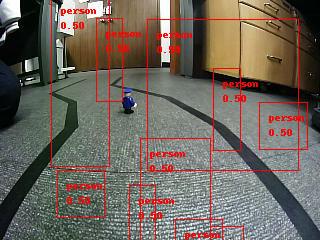

In [44]:
image = image.convert('RGB')
draw_objects(ImageDraw.Draw(image), objs, labels)

display(image)